## Análisis Exploratorio para modelo sold quantity

Para este análisis se usara el df generado en el primer notebook. Tambien se generaran las variables que sean necesarias de analisis exploratorio anterior.

Recordemos que se registraron 31847 observaciones para 32 categorias.



In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set(rc={'figure.figsize':(10, 5)})

In [2]:
df_total = pd.read_csv("df_total_original.csv")

### Análisis y creacion de features para modelo

queremos predecir la cantidad vendida por lo que vamos a trabajar con la feature listing_type_id ya que representa categoria de la publicacion.

Vemos que las categorias van desde gold_special hasta bronze

In [3]:
#feature creada en notebook anterior
df_total['tiene_descuento'] = ~df_total.original_price.isnull()


Vamos a calcular el valor sin descuento como hicimos en el notebook anterior. Lo unico es que ahora tambien tenemos que incluir a los productos que no tienen descuento, ya que el modelo usara todos los datos, en este caso el valor del descuento es 0

In [4]:
df_total.loc[df_total.original_price.isnull(),'vlr_descuento']=0
df_total.loc[~df_total.original_price.isnull(),'vlr_descuento']=round(1-df_total['price']/df_total['original_price'],2)

In [5]:
#veamos una lista de las features que tenemos hasta el momento
df_total.columns

Index(['Unnamed: 0', 'id', 'site_id', 'title', 'price', 'currency_id',
       'available_quantity', 'sold_quantity', 'buying_mode', 'listing_type_id',
       'condition', 'accepts_mercadopago', 'address__state_name',
       'address__city_name', 'shipping__free_shipping',
       'shipping__store_pick_up', 'original_price', 'category_id',
       'official_store_id', 'catalog_product_id', 'attributes__marca',
       'attributes__modelo', 'categoria_principal', 'tiene_descuento',
       'vlr_descuento'],
      dtype='object')

### Variable sold_quantity

La variable de respuesta es sold_quantity. Tener en cuenta que esta variable no presenta los valores reales de la cantidad vendida sino que esta codificada segun se explica en:
[Fuente Items y Busquedas.](https://developers.mercadolibre.com.ar/es_ar/items-y-busquedas#Valores-en-campos-sold-quantity-y-available-quantity)


In [6]:
#analicemos la distribucion de la variable en cada uno de sus valores
df_total.sold_quantity.value_counts()/len(df_total)*100

500     20.055991
0       11.613350
250      8.131232
5        6.363436
50       5.514139
          ...    
1194     0.003146
495      0.003146
1405     0.003146
1960     0.003146
410      0.003146
Name: sold_quantity, Length: 1152, dtype: float64

notar que mismo siendo muchos los valores de sold quantity. Los valores 500, 0, 250,5y 50 representan un porcentaje alto de los datos

In [7]:
df_total.sold_quantity.nunique()

1152

In [8]:
df_total.sold_quantity.describe()

count    31791.000000
mean       401.894593
std       1618.308768
min          0.000000
25%          6.000000
50%        100.000000
75%        500.000000
max      50000.000000
Name: sold_quantity, dtype: float64

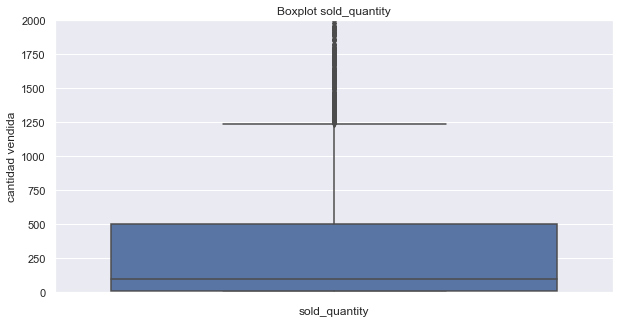

In [9]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(y="sold_quantity", data=df_total)
plt.title('Boxplot sold_quantity')
_ = plt.setp(ax.get_xticklabels(), rotation=90)
plt.ylim((0, 2e3))
plt.xlabel('sold_quantity')
plt.ylabel('cantidad vendida')
plt.show()


Notar que la variable no esta codificada como se explica en [Fuente Items y Busquedas.](https://developers.mercadolibre.com.ar/es_ar/items-y-busquedas#Valores-en-campos-sold-quantity-y-available-quantity)

Asumo que la variable sold_quantity no esta codificada como deberia (por la cantidad de valores que aparecen) y vamos a codificar la variable tal cual esta explicado en la pagina de mercado libre. En el link  [Fuente Items y Busquedas.](https://developers.mercadolibre.com.ar/es_ar/items-y-busquedas#Valores-en-campos-sold-quantity-y-available-quantity) se puede chequear la tabla con el codigo. La idea de codificar esta variable es para hacer un modelo de clasificacion en vez de uno de regresion. Es decir en vez de predecir el valor exacto de la venta vamos a predecir el rango donde se encuentra.

In [10]:
df_total.loc[(df_total.sold_quantity>5) & (df_total.sold_quantity< 26),'sold_quantity']=5
df_total.loc[(df_total.sold_quantity>25) & (df_total.sold_quantity< 51),'sold_quantity']=25
df_total.loc[(df_total.sold_quantity>50) & (df_total.sold_quantity< 101),'sold_quantity']=50
df_total.loc[(df_total.sold_quantity>100) & (df_total.sold_quantity< 151),'sold_quantity']=100
df_total.loc[(df_total.sold_quantity>150) & (df_total.sold_quantity< 201),'sold_quantity']=150
df_total.loc[(df_total.sold_quantity>200) & (df_total.sold_quantity< 251),'sold_quantity']=200
df_total.loc[(df_total.sold_quantity>250) & (df_total.sold_quantity< 501),'sold_quantity']=250
df_total.loc[(df_total.sold_quantity>500) & (df_total.sold_quantity< 5000),'sold_quantity']=500
df_total.loc[df_total.sold_quantity>5000,'sold_quantity']=5000

In [11]:
#analicemos la distribucion de la variable en cada uno de sus valores
df_total.sold_quantity.value_counts()/len(df_total)*100

250     22.424586
5       16.715423
0       11.613350
25       9.351703
200      9.043440
50       8.496115
100      5.337989
150      4.023151
5000     3.309113
500      2.903337
1        2.245919
2        1.862162
4        1.355730
3        1.317983
Name: sold_quantity, dtype: float64

Ahora los valores son los que explica en la pagina tener en cuenta al interpretar el resultado que el mismo es un codigo de un rango de valores.
notemos que las clases no estan balanceadas. Y puede ser que algunas clases no tengan peso en el modelo. Hay tecnicas para balancear clases (undersampling, oversampling), pero en este caso no creo oportuno usarlas. Lo que se puede hacer es lusar metricas adecuadas para ver el  accuracy dentro de  la clases. Luego decidir si esto es un problema para el modelo entrenado. y si llegase a ser un problema se puede aplicar alguna tecnica para balancear (suelen ser hacer un sampling random de todas las clases para mantener el mismo porcentaje. lo que nos haria perder muchisimos datos. o sino crear datos de las clases menos representadas. Pero esto tambien tiene sus problemas).

### Feature available_quantity cantidad disponible

La variable en available quantity en teoria tambien esta codificada como sold_quantity segun [Fuente Items y Busquedas.](https://developers.mercadolibre.com.ar/es_ar/items-y-busquedas#Valores-en-campos-sold-quantity-y-available-quantity)

In [12]:
df_total.available_quantity.value_counts()/len(df_total)*100

1       44.952974
50       7.272499
500      6.973672
250      4.318832
100      3.315404
          ...    
316      0.003146
1275     0.003146
946      0.003146
376      0.003146
4506     0.003146
Name: available_quantity, Length: 828, dtype: float64

Nuevamente esta variable no esta codificada como se explica en la pagina (desconzco el origen del error) pero vamos a codificarla segun la tabla

In [13]:
df_total.loc[(df_total.available_quantity>=1) & (df_total.available_quantity<= 50),'available_quantity']=1
df_total.loc[(df_total.available_quantity>=51) & (df_total.available_quantity<= 100),'available_quantity']=50
df_total.loc[(df_total.available_quantity>=101) & (df_total.available_quantity<= 150),'available_quantity']=100
df_total.loc[(df_total.available_quantity>=151) & (df_total.available_quantity<= 200),'available_quantity']=150
df_total.loc[(df_total.available_quantity>=201) & (df_total.available_quantity<= 250),'available_quantity']=200
df_total.loc[(df_total.available_quantity>=251) & (df_total.available_quantity<= 500),'available_quantity']=250
df_total.loc[(df_total.available_quantity>=501) & (df_total.available_quantity<= 5000),'available_quantity']=500
df_total.loc[(df_total.available_quantity>=5001) & (df_total.available_quantity<= 50000),'available_quantity']=5000
df_total.loc[(df_total.available_quantity>=50001) & (df_total.available_quantity<= 99999),'available_quantity']=50000

In [14]:
df_total.available_quantity.value_counts()/len(df_total)*100

1        71.523387
250       8.266491
50        5.998553
200       4.686861
500       3.318549
100       3.186436
150       2.110660
5000      0.893335
50000     0.015728
Name: available_quantity, dtype: float64

Ahora vamos a realizar un grafico de barras para ver como se distribuye para las cantidades vendidas la cantidad disponible

<Figure size 720x720 with 0 Axes>

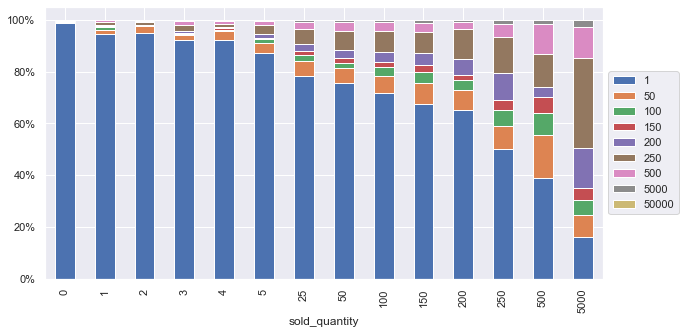

In [15]:
plt.figure(figsize = (10, 10))
df_total.groupby(['sold_quantity','available_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

vemos que la cantidad de items disponibles  entre 1-50 es la que ocupa el mayor porcentaje salvo en la clase de sold quantity 5000.
mismo asi a medida que se vende mas comienzan a tomar mayor peso cantidades mas grandes de productos disponibles (lo que es logico). 

De este grafico nos queda la idea que la variable abailable quantity no va a ser de mucha utilidad para predecir la sold quantity (por lo menos en los valores de mayor representatividad).

### Vamos a analizar la relacion entre nivel de descuento y la cantidad vendida

* una hipotesis podria ser que a mayor descuento mas ventas (porque para eso esta el descuento)
* otra hipotesis podria ser que a mayor descuento menos ventas. Pensando que el producto tiene tanto descuento porque no se vende.

Veamos los datos

Como vimos en los notebooks anteriores el 16% de productos en el marketplace tiene descuento. 

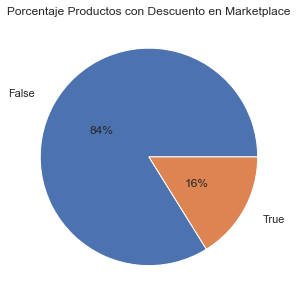

In [16]:
df_total.tiene_descuento.value_counts().sort_index().plot.pie(ylabel = '',  autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
plt.title('Porcentaje Productos con Descuento en Marketplace')
plt.show()

Text(0, 0.5, 'descuento del producto')

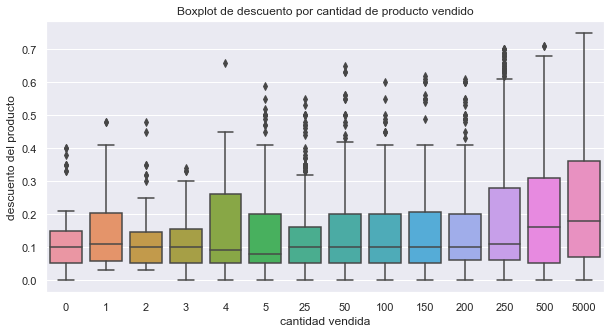

In [17]:
plt.figure(figsize=(10,5))
ax=sns.boxplot(x="sold_quantity",y="vlr_descuento",data= df_total[df_total.tiene_descuento])
plt.title('Boxplot de descuento por cantidad de producto vendido')
plt.xlabel('cantidad vendida')
plt.ylabel('descuento del producto')

de este grafico se ve que el descuento se mantiene relativamente parejo en las cantidades vendidas hasta la categoria 250. En las cantidades vendidas mas masivas el descuento es mayor. Y estas categorias (500 y 5000) tienen distribución bastante parecida.  En resumen los productos de venta mas "masiva" tienen mayor descuento. Podria ser una variable util a incluir en el modelo.



### Categoría
Vamos a analizar la influencia de las categorias en la cantidad vendida. Haremos un grafico para ver cómo influyen las mismas

<Figure size 720x720 with 0 Axes>

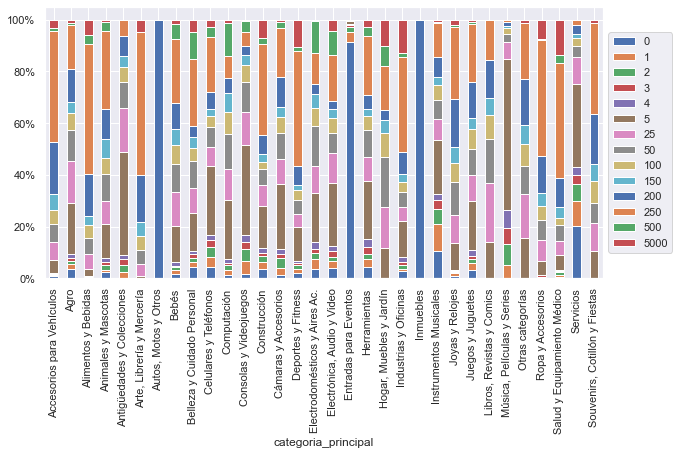

In [18]:
plt.figure(figsize=(10,10))
df_total.groupby(['categoria_principal','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [19]:
df_total.categoria_principal.unique()

array(['Accesorios para Vehículos', 'Agro', 'Alimentos y Bebidas',
       'Animales y Mascotas', 'Antigüedades y Colecciones',
       'Arte, Librería y Mercería', 'Autos, Motos y Otros', 'Bebés',
       'Belleza y Cuidado Personal', 'Cámaras y Accesorios',
       'Celulares y Teléfonos', 'Computación', 'Consolas y Videojuegos',
       'Construcción', 'Deportes y Fitness',
       'Electrodomésticos y Aires Ac.', 'Electrónica, Audio y Video',
       'Entradas para Eventos', 'Herramientas', 'Hogar, Muebles y Jardín',
       'Industrias y Oficinas', 'Inmuebles', 'Instrumentos Musicales',
       'Joyas y Relojes', 'Juegos y Juguetes',
       'Libros, Revistas y Comics', 'Música, Películas y Series',
       'Ropa y Accesorios', 'Salud y Equipamiento Médico', 'Servicios',
       'Souvenirs, Cotillón y Fiestas', 'Otras categorías'], dtype=object)

In [20]:
df_total.loc[df_total['categoria_principal']=='Autos, Motos y Otros','sold_quantity'].unique()

array([0], dtype=int64)

Vemos que en inmuebles y Autos, Motos y Otros la cantidad vendida es 0. 

**Entonces podriamos emplear una regla antes de correr el modelo si categoria es: nmuebles o Autos, Motos y Otros la prevision de ventas del modelo es 0.**

Por esto de ahora en mas vamos a sacar estos datos del entrenamiento del modelo.

In [21]:
df_sin_dos_categorias=df_total[~df_total.categoria_principal.isin(['Autos, Motos y Otros','Inmuebles'])]

In [22]:
df_sin_dos_categorias.columns

Index(['Unnamed: 0', 'id', 'site_id', 'title', 'price', 'currency_id',
       'available_quantity', 'sold_quantity', 'buying_mode', 'listing_type_id',
       'condition', 'accepts_mercadopago', 'address__state_name',
       'address__city_name', 'shipping__free_shipping',
       'shipping__store_pick_up', 'original_price', 'category_id',
       'official_store_id', 'catalog_product_id', 'attributes__marca',
       'attributes__modelo', 'categoria_principal', 'tiene_descuento',
       'vlr_descuento'],
      dtype='object')

### Tipo de publicacion (listing type id) vamos a analizar si esta categoria esta relacionada con las ventas.

El tipo de publicacion esta relacionado con la cantidad de exposicion que va a tener la publicacion.

<Figure size 720x720 with 0 Axes>

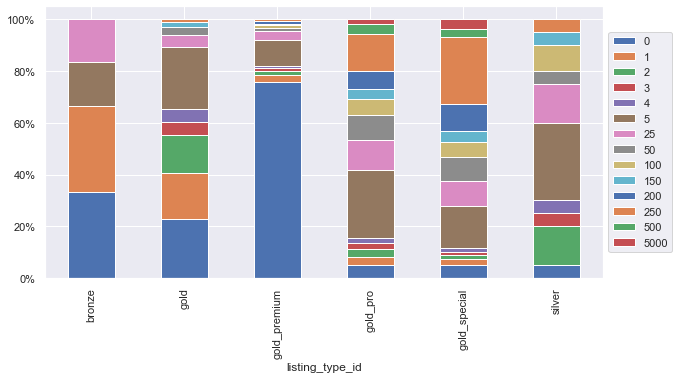

In [23]:
plt.figure(figsize=(10,10))
df_total.groupby(['listing_type_id','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Algunas conclusiones del grafico:
* Si la publicacion es bronze a lo sumo se puede vender en el rango 25-50 unidades

* gold_pro y gold_special son las unicas categorias que admiten vender > 5000 productos

* gold_premium tiene mas del 75% de sus ventas en 0. Si el producto pertenece a esta categoria deberian subir las chances de que la prevision sea 0


Creo que esta feature puede resultar interesante para incluir en el modelo

### Condicion de producto: Productos nuevos o usados

ahora analizaremos si la condicion de producto esta ligada al numero de ventas:

C:\Users\MAGDAL~1\AppData\Local\Temp/ipykernel_9452/2197123551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_dos_categorias['is_new'] = df_sin_dos_categorias.condition=='new'


<Figure size 720x720 with 0 Axes>

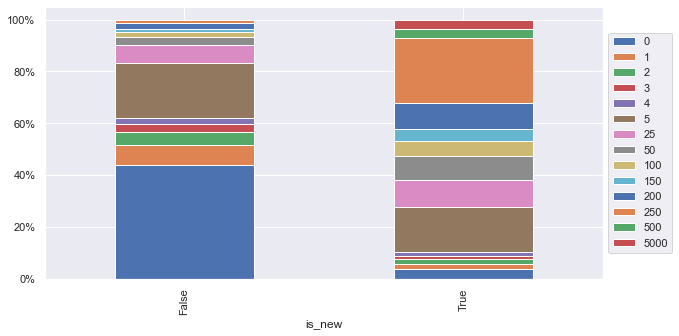

In [24]:
plt.figure(figsize = (10, 10))
df_sin_dos_categorias['is_new'] = df_sin_dos_categorias.condition=='new'

df_sin_dos_categorias.groupby(['is_new','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Parece que la variable is_new va a ser de utilidad para para predecir la cantidad vendida. Si el producto es nuevo parece muy poco probable que la cantidad vendida este en los rangos mas bajos no asi si el producto es usado (aclaro que el modelo final es multivariable y obviamente cruza todas las variables juntas. Esto es un analisis que se hace a simple vista para entender las features e incorporar features de importancia)

### Precio de la publicacion. Vamos a analizar la variable precio de la publicacion.
La misma como vimos anteriormente cuenta con mucha dispersion. vamos a chequear si esta dispersion se mantiene dentro de cada categoria

In [25]:
#antes que nada hagamos un describe
df_sin_dos_categorias.price.describe()

count    2.947700e+04
mean     1.515984e+04
std      5.617495e+04
min      1.000000e+00
25%      1.495000e+03
50%      4.000000e+03
75%      1.099000e+04
max      5.752557e+06
Name: price, dtype: float64

como sabiamos la variable tiene alta dispersion. veamos si se mantiene por categoria. Vamos a hacer unos graficos y sacar unas conclusiones preliminares:



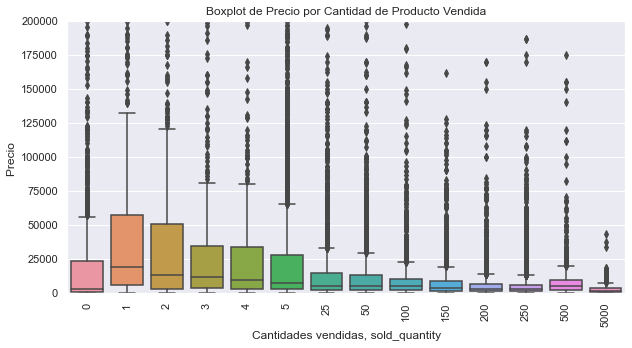

In [26]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="price", data=df_sin_dos_categorias)
plt.title('Boxplot de Precio por Cantidad de Producto Vendida')
plt.ylim((0, 2e5))
plt.xlabel('Cantidades vendidas, sold_quantity')
plt.ylabel('Precio ')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

La variable precio puede guardar una correlacion util para el modelo (mas alla de su enorme dispersion)

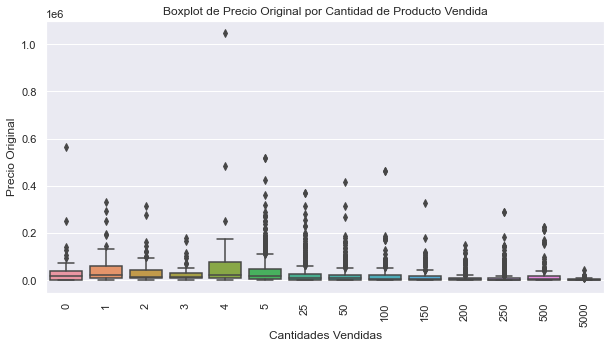

In [27]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="original_price", data=df_sin_dos_categorias)
plt.title('Boxplot de Precio Original por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Precio Original')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

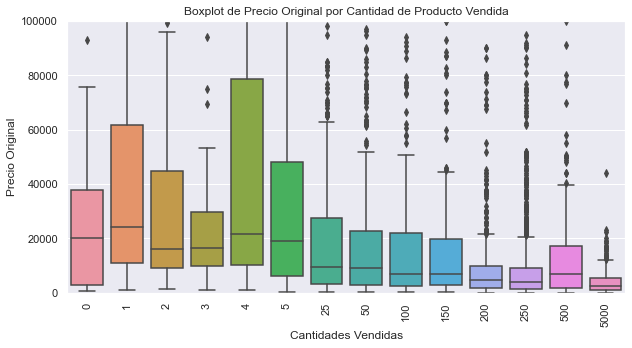

In [28]:
#miremos mas de cerca
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="original_price", data=df_sin_dos_categorias)
plt.title('Boxplot de Precio Original por Cantidad de Producto Vendida')
plt.ylim((0, 1e5))
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Precio Original')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

vemos que el precio original tambien puede guardar una informacion util para el modelo(por ejemplo si el precio esta por sobre 40000 se restringen los rangos de la cantidad vendida posible dejando afuera las cantidades mas grandes). Con la variable precio y valor de descuento ya se incluye implicitamente el precio original.

## Resultados de exploratorio y planteo del modelo

miremos nuevamente la distribucion porcentual de cada clase en los datos que tenemos

In [29]:
df_sin_dos_categorias.sold_quantity.value_counts()/len(df_sin_dos_categorias)*100

250     23.930046
5       17.837602
25       9.979524
200      9.650566
50       9.066497
100      5.696351
0        5.679568
150      4.293243
5000     3.531268
500      3.098251
1        2.396697
2        1.987177
4        1.446746
3        1.406465
Name: sold_quantity, dtype: float64

#### Del exploratorio anterior decidimos:

- Usar las features **total.listing_type_id, price, is_new, tiene_descuento, descuento de producto, categoria  y price** Por el momento saco la variable precio original de las features del modelo (ya que tiene valores muy altos y mucha dispersion). Si el modelo no da bien voy a probar incluirla
-  Si las categorias son **'Autos, Motos y Otros','Inmuebles' -> sold_quantity=0**
- Por ultimo veo dificil que podamos predecir con accuracy en cada categoria tal cual estan divididas. El approach que voy a tomar es agrupar de la siguiente forma: **categoria_1= sold_quantity rango 1-4 categoria_500 = sold_quantity >=500**

### Modelo: creacion de Features

pre modelo se corre una condicion si las categorias son Autos,... o Inmuebles la prediccion es 0. Sino se corre el modelo

In [30]:
# vamos a agrupar las categorias segun dijimos. Creo que son similares y no se pueden diferencias y tambien balancea la representatividad de cada una.
# Además que no pareciera haber información para discriminarlas. 

df_sin_dos_categorias['is_new'] = 1*(df_sin_dos_categorias.condition.isin(['new'])) 
###############
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity < 5, 'sold_group'] = 1
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity == 0, 'sold_group'] = 0
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity >= 500, 'sold_group'] = 500
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity == 5, 'sold_group'] = 5
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity == 25, 'sold_group'] = 25
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity == 50, 'sold_group'] = 50
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity == 100, 'sold_group'] = 100
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity == 150, 'sold_group'] = 150
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity == 200, 'sold_group'] = 200
df_sin_dos_categorias.loc[df_sin_dos_categorias.sold_quantity == 250, 'sold_group'] = 250


C:\Users\MAGDAL~1\AppData\Local\Temp/ipykernel_9452/1993868033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_dos_categorias['is_new'] = 1*(df_sin_dos_categorias.condition.isin(['new']))
C:\Users\Magdalena\anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Magdalena\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [31]:
df_sin_dos_categorias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29791 entries, 0 to 31790
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               29791 non-null  int64  
 1   id                       29791 non-null  object 
 2   site_id                  29791 non-null  object 
 3   title                    29791 non-null  object 
 4   price                    29477 non-null  float64
 5   currency_id              29477 non-null  object 
 6   available_quantity       29791 non-null  int64  
 7   sold_quantity            29791 non-null  int64  
 8   buying_mode              29791 non-null  object 
 9   listing_type_id          29791 non-null  object 
 10  condition                28791 non-null  object 
 11  accepts_mercadopago      29791 non-null  bool   
 12  address__state_name      29791 non-null  object 
 13  address__city_name       29791 non-null  object 
 14  shipping__free_shippin

In [32]:
#saquemos los valores null de la variable price
df_sin_dos_categorias = df_sin_dos_categorias[df_sin_dos_categorias['price'].notna()]

In [33]:
features = ['listing_type_id', 'is_new','tiene_descuento', 'vlr_descuento', 'price',
            
            'categoria_principal']
X = df_sin_dos_categorias[features]


In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29477 entries, 0 to 31790
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   listing_type_id      29477 non-null  object 
 1   is_new               29477 non-null  int32  
 2   tiene_descuento      29477 non-null  bool   
 3   vlr_descuento        29477 non-null  float64
 4   price                29477 non-null  float64
 5   categoria_principal  29477 non-null  object 
dtypes: bool(1), float64(2), int32(1), object(2)
memory usage: 1.3+ MB


Nota: para un modelo mas detallado lo que haria es analizar todas las features. incorporar el mayor numero de las mismas que considere relevantes y luego segun importancia sacar alguna si fuese necesario. Para este analisis vamos a probar si es posible hacer un modelo razonable con estas features.

* Notar que las variables **categoria_principal, tiene_descuento, listing_type_id** tienen valores no numericos. La mayoria de los algoritmos no pueden manejar valores no numericos. 

* Notar que la **variable tiene_descuento** es booleana la vamos a codificar con el codigo True=1 False es igual a 0.

* notar que la variable **listing_type_id** es categorica ordinal. es decir tiene un orden por lo que la vamos a codificar con un diccionario

* Por ultimo para codificar **categoria_principal** podriamos hacerlo con un diccionario remplazando cada nombre de categoria por un numero. El tema es que en estas situaciones donde no importa el orden este tipo de codificacion puede llevarnos a una mala performance del modelo. Lo que vamos a hacer es crear una nueva variable binaria para esto vamos a usar get_dummies() de pandas



Empecemos con codificar tiene descuento que es mas simple:

In [35]:
X.tiene_descuento.unique()

array([False,  True])

In [36]:
X['tiene_descuento']=X['tiene_descuento'].replace({True:1 , False:0})

C:\Users\MAGDAL~1\AppData\Local\Temp/ipykernel_9452/2715349292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tiene_descuento']=X['tiene_descuento'].replace({True:1 , False:0})


In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29477 entries, 0 to 31790
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   listing_type_id      29477 non-null  object 
 1   is_new               29477 non-null  int32  
 2   tiene_descuento      29477 non-null  int64  
 3   vlr_descuento        29477 non-null  float64
 4   price                29477 non-null  float64
 5   categoria_principal  29477 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 1.5+ MB


pasemos a codificar el tipo de publicacion

In [38]:
X.listing_type_id.unique()

array(['gold_special', 'gold_pro', 'gold_premium', 'gold', 'bronze',
       'silver'], dtype=object)

In [39]:
# creamos un diccionario ordinal a mapeo de enteros
ordinal = {'bronze':1, 
            'silver':2, 
            'gold':3, 
            'gold_special':4, 
            'gold_pro':5, 
            'gold_premium':6}
# apply using map
X['listing_type_id'] = X.listing_type_id.map(ordinal)

C:\Users\MAGDAL~1\AppData\Local\Temp/ipykernel_9452/1347314805.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['listing_type_id'] = X.listing_type_id.map(ordinal)


Pasemos a codificar las categorias:

In [40]:
nominal_features=X[['categoria_principal']].copy()
nominal_features=pd.get_dummies(nominal_features,drop_first=True)
nominal_features.head()

,categoria_principal_Agro,categoria_principal_Alimentos y Bebidas,categoria_principal_Animales y Mascotas,categoria_principal_Antigüedades y Colecciones,"categoria_principal_Arte, Librería y Mercería",categoria_principal_Bebés,categoria_principal_Belleza y Cuidado Personal,categoria_principal_Celulares y Teléfonos,categoria_principal_Computación,categoria_principal_Consolas y Videojuegos,...,categoria_principal_Instrumentos Musicales,categoria_principal_Joyas y Relojes,categoria_principal_Juegos y Juguetes,"categoria_principal_Libros, Revistas y Comics","categoria_principal_Música, Películas y Series",categoria_principal_Otras categorías,categoria_principal_Ropa y Accesorios,categoria_principal_Salud y Equipamiento Médico,categoria_principal_Servicios,"categoria_principal_Souvenirs, Cotillón y Fiestas"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X = pd.concat([X, nominal_features], axis=1)

In [42]:
X.head()

,listing_type_id,is_new,tiene_descuento,vlr_descuento,price,categoria_principal,categoria_principal_Agro,categoria_principal_Alimentos y Bebidas,categoria_principal_Animales y Mascotas,categoria_principal_Antigüedades y Colecciones,...,categoria_principal_Instrumentos Musicales,categoria_principal_Joyas y Relojes,categoria_principal_Juegos y Juguetes,"categoria_principal_Libros, Revistas y Comics","categoria_principal_Música, Películas y Series",categoria_principal_Otras categorías,categoria_principal_Ropa y Accesorios,categoria_principal_Salud y Equipamiento Médico,categoria_principal_Servicios,"categoria_principal_Souvenirs, Cotillón y Fiestas"
0,4,1,0,0.00,1729.80,Accesorios para Vehículos,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,1,0,0.00,3499.00,Accesorios para Vehículos,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,0,0.00,2159.99,Accesorios para Vehículos,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0.00,7810.00,Accesorios para Vehículos,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,1,0.11,3470.11,Accesorios para Vehículos,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
X = X.drop('categoria_principal', 1)

C:\Users\MAGDAL~1\AppData\Local\Temp/ipykernel_9452/106017119.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X.drop('categoria_principal', 1)


In [44]:
X[X.isnull().any(axis=1)]

,listing_type_id,is_new,tiene_descuento,vlr_descuento,price,categoria_principal_Agro,categoria_principal_Alimentos y Bebidas,categoria_principal_Animales y Mascotas,categoria_principal_Antigüedades y Colecciones,"categoria_principal_Arte, Librería y Mercería",...,categoria_principal_Instrumentos Musicales,categoria_principal_Joyas y Relojes,categoria_principal_Juegos y Juguetes,"categoria_principal_Libros, Revistas y Comics","categoria_principal_Música, Películas y Series",categoria_principal_Otras categorías,categoria_principal_Ropa y Accesorios,categoria_principal_Salud y Equipamiento Médico,categoria_principal_Servicios,"categoria_principal_Souvenirs, Cotillón y Fiestas"


In [45]:
#VER############
#Transformamos el dataframe en un numpy array. No es obligatorio scikit lo convierte internamente pero es mas seguro.
#X = np.array(X)

In [46]:
 #como dije no creo que se pueda predecir con tanto detalle las categorias por lo que vamos a poner como target sold group. Luego en funcion del tiempo que tenga y resultados del modelo podria probar si mejora poniendo de target sold_quantity
target = ['sold_group']

In [52]:
#creamos variable de respuesta
y = df_sin_dos_categorias[target].astype('int64')
#y = np.array(df_sin_dos_categorias[target])

##  Modelo  yTrain y Test sets

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [49]:
from sklearn import metrics

Antes de hacer un modelo vamos a hacer un modelo base para comparar. La idea es tener una base que puede ser por ejemplo el promedio de las ventas si nuestra prediccion no puede superar esto obviamente no es muy buena

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [55]:
clf = RandomForestClassifier(n_estimators=2000)
clf = clf.fit(X_train, y_train.values.ravel())
#clf = clf.fit(X_train, y_train)

In [51]:
prediction = clf.predict(X_test)

In [52]:
prediction_train = clf.predict(X_train)

En esta parte hicimos el split entre train y test y entrenamos un modelo de random forest (suele ser un modelo rapido y que performa bien y relativamente simple por lo que me parecio una buena eleccion para probar).
Una vez que tenemos el modelo predecimos que en el set de testeo (que obvio no usamos para entrenar). Y luego tambien predijimos con el set de entrenamiento para chequear overfiting.  Es decir que el modelo prediga muy bien en el set de entrenamiento pero no tenga capacidad predictiva real.

Para medir la performance del modelo vamos a usar el accuracy para tener una idea general y despues mirar mas en detalle la matriz de confusion. El accuracy  intuitivo pero el modelo puede ser malo prediciendo en las clases menos representadas y mismo asi tener buen accuracy. Por esto tambien miraremos la matriz de confusion.

In [56]:
print(metrics.confusion_matrix(y_test, prediction))

[[198  34  41  13  10   6   3   3  13   4]
 [ 35 116 144  26  20  13   4  13  29   9]
 [ 29 155 415 116 100  54  22  63 117  33]
 [ 18  30 137  94  70  41  21  50  94  23]
 [  6  28 118  68  66  38  27  41  82  34]
 [  6  16  57  37  50  22  19  35  75  18]
 [  2   7  50  29  20  21  13  38  74  13]
 [  7  17  64  44  46  36  26  85 224  23]
 [  5  20 116  94 107  62  51 169 673 142]
 [  5   7  26  22  21  11  16  23 152  76]]


Vamos a imprimir precision y recall y verlas por clase

In [57]:
print(metrics.classification_report(y_test, prediction, digits=3))

              precision    recall  f1-score   support

         0.0      0.637     0.609     0.623       325
         1.0      0.270     0.284     0.277       409
         5.0      0.355     0.376     0.365      1104
        25.0      0.173     0.163     0.168       578
        50.0      0.129     0.130     0.130       508
       100.0      0.072     0.066     0.069       335
       150.0      0.064     0.049     0.055       267
       200.0      0.163     0.149     0.156       572
       250.0      0.439     0.468     0.453      1439
       500.0      0.203     0.212     0.207       359

    accuracy                          0.298      5896
   macro avg      0.251     0.250     0.250      5896
weighted avg      0.291     0.298     0.294      5896



Predice la clase 0 con un f1 del 62% y balance entre precision y recall. El resto de las clases las predice con muy baja accuracy. 
Ploteemos la matriz de confusion para mirar en detalle y con colores

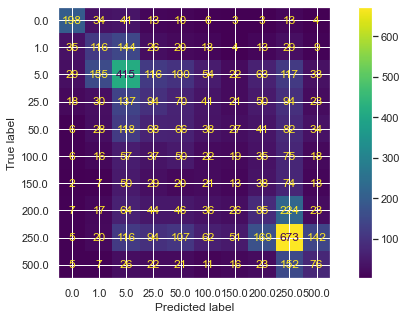

In [63]:
plot_confusion_matrix(clf, X_test, y_test)  

In [58]:
round(accuracy_score(y_test,prediction),2)

0.3

In [59]:
round(accuracy_score(y_train,prediction_train),2)

0.86

In [61]:
print(metrics.classification_report(y_train, prediction_train, digits=3))

              precision    recall  f1-score   support

         0.0      0.956     0.942     0.949      1258
         1.0      0.909     0.844     0.875      1716
         5.0      0.834     0.915     0.872      4128
        25.0      0.857     0.805     0.830      2356
        50.0      0.865     0.825     0.844      2174
       100.0      0.861     0.759     0.807      1352
       150.0      0.900     0.724     0.802      1006
       200.0      0.824     0.800     0.812      2294
       250.0      0.856     0.925     0.889      5681
       500.0      0.894     0.864     0.879      1616

    accuracy                          0.863     23581
   macro avg      0.875     0.840     0.856     23581
weighted avg      0.864     0.863     0.862     23581



Tenemos un modelo que ajusta muy bien en el train set pero no asi en el set de testeo. Esto al ser el modelo random forest no necesariamente implica overfiting pero si es un problema grande ya que el set de testeo es el set donde las metricas del modelo nos hablan de su capacidad predictiva. En este caso creo que los problemas son:

- **tamaño de muestra.** La cantidad de datos tomados son muy pocos para que el modelo tenga una buena capacidad predictiva. Con mas tiempo intentaria bajar los datos por medio de una aplicacion y bajar mas cantidad de datos. minimo 10000 valores por producto. 

- **Otro problema puede ser que falten features necesarias para realizar la prediccion** por ejemplo no tengo la **antiguedad de la publicacion** la cual obviamente esta relacionada con la cantidad de ventas.

- Pordria intentar tunear los hiperparametros del modelo pero creo que las dos anteriores tienene mucho mayor peso y como el modelo no es ni siquiera bueno no me parece valga la pena.

**Voy a probar:**

* Otro modelo
* si esto no funciona agregar alguna feature que no tenga y pudiese ser relevante y recolectar mas cantidad de datos



In [56]:
#para tener una idea voy a calcular la importancia de cada feature
clf.feature_importances_

array([0.01350831, 0.00931462, 0.00654674, 0.04945359, 0.78665842,
       0.00287531, 0.00325293, 0.00190742, 0.00606127, 0.00423848,
       0.0027841 , 0.00301189, 0.00257262, 0.0036966 , 0.00464351,
       0.00296321, 0.00310678, 0.00366845, 0.00320767, 0.00315732,
       0.03174544, 0.00294128, 0.00415641, 0.00336105, 0.00369187,
       0.00266052, 0.00288162, 0.0030422 , 0.01495887, 0.00249818,
       0.00344572, 0.00319301, 0.00307665, 0.00171796])

In [58]:
feature_names=X.columns

<BarContainer object of 34 artists>

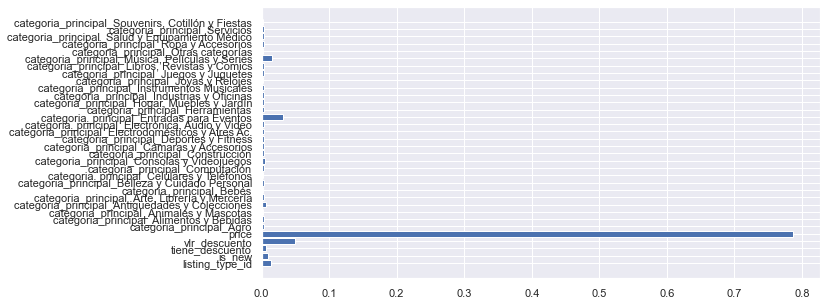

In [60]:
plt.barh(feature_names, clf.feature_importances_)

### XGBoost Classifier
Vamos a probar XGBoost classifier para comparar la performance. XGBoost es uno de los modelos mas performantes de machine learning y de los mejores modelos ensemble (que usan otro modelos y promedian). 

In [62]:
import xgboost; print(xgboost.__version__)

1.5.1


In [66]:
from xgboost import XGBClassifier

In [68]:
model = XGBClassifier()
#model.fit(X_train, y_train)
model.fit(X_train, y_train.values.ravel()

C:\Users\Magdalena\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Magdalena\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:37] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [69]:
y_pred = model.predict(X_test)

In [70]:
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.820     0.618     0.705       325
           1      0.349     0.215     0.266       409
           5      0.374     0.580     0.455      1104
          25      0.192     0.090     0.122       578
          50      0.220     0.091     0.128       508
         100      0.080     0.006     0.011       335
         150      0.125     0.004     0.007       267
         200      0.162     0.037     0.060       572
         250      0.410     0.804     0.543      1439
         500      0.252     0.159     0.195       359

    accuracy                          0.384      5896
   macro avg      0.298     0.260     0.249      5896
weighted avg      0.319     0.384     0.317      5896



In [71]:
y_pred_train = model.predict(X_train)
print(metrics.classification_report(y_train, y_pred_train, digits=3))

              precision    recall  f1-score   support

           0      0.882     0.669     0.761      1258
           1      0.620     0.350     0.448      1716
           5      0.445     0.695     0.542      4128
          25      0.514     0.244     0.331      2356
          50      0.525     0.190     0.279      2174
         100      0.719     0.078     0.140      1352
         150      0.828     0.048     0.090      1006
         200      0.475     0.128     0.202      2294
         250      0.436     0.875     0.582      5681
         500      0.502     0.334     0.401      1616

    accuracy                          0.477     23581
   macro avg      0.595     0.361     0.378     23581
weighted avg      0.532     0.477     0.426     23581



El modelo XGBoost funciona mejor que el random forest tenemos un accuracy mejor en general y precision y recall tambien son mejores en todas las clases. Me quedo con este modelo entonces claro que igualmente el accuracy es bajo. Ahora voy a bajar mas datos y ver si puedo agregar otras features